In [1]:
import numpy as np
import scipy

import poly
import sym_qsp_opt

import matplotlib.pyplot as plt

In [2]:
#######################################################
#                                                     #
#                 INVERSE APPROX                      #
#                                                     #
#######################################################

# Generate inverse polynomial approximation
pg = poly.PolyOneOverX()

# Underlying parameters of inverse approximation.
# We use return_scale=True for ease of plotting correct desired function.
kappa=5
epsilon=0.001
pcoefs, scale = pg.generate(kappa=kappa, epsilon=epsilon, chebyshev_basis=True, return_scale=True)

# Generate anonymous approximation and ideal function for scaled reciprocal.
inv_fun = lambda x: np.polynomial.chebyshev.chebval(x, pcoefs)
ideal_fun = lambda x: scale*np.reciprocal(x)

# Using odd parity and instantiating desired coefficeints.
parity = 1
coef = pcoefs[parity::2]

# Optimize to the desired function using Newton solver.
crit = 1e-12
(phases, err, total_iter, qsp_seq_opt) = sym_qsp_opt.newton_solver(coef, parity, crit=crit)
print("phase len: %s\nerror: %s\niter: %s\n"%(str(len(phases)), str(err), str(total_iter)))

# Generate samples for plotting.
num_samples = 400
sample_0 = np.linspace(-1, -1.0/10000,num=num_samples)
sample_1 = np.linspace(1.0/10000,1,num=num_samples)
# Adding NaN between ranges to remove plotting artifacts.
samples = np.concatenate((sample_0, [float('NaN')], sample_1))

# Grab im part of QSP unitary top-left matrix element.
im_vals = np.array(qsp_seq_opt.gen_response_im(samples))

b=212, j0=53
[PolyOneOverX] minimum [-9.30573232] is at [-0.07702084]: normalizing
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 1000.
iter: 001 --- err: 1.888e-01


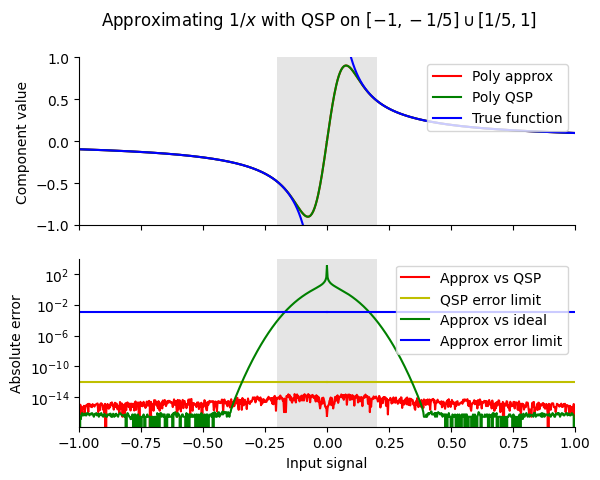

In [ ]:
# Generate plotted values.
approx_vals = np.array(list(map(inv_fun, samples)))
# NOTE: For some reason this map casts to have an additional dimension.
ideal_vals = np.array(list(map(ideal_fun, samples)))[:,0]

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Approximating $1/x$ with QSP on $[-1,-1/5]\\cup[1/5, 1]$')

# Plot achieved QSP protocol along with approximating polynomial.
axs[0].plot(samples, approx_vals, 'r', label="Poly approx")
axs[0].plot(samples, im_vals, 'g', label="Poly QSP")
axs[0].plot(samples, ideal_vals, 'b', label="True function")

# Plot difference between two on log-plot
diff = np.abs(im_vals - approx_vals)
approx_diff = np.abs(ideal_vals - approx_vals)

# Plot QSP output polynomial versus desired polynomial, and error bound.
axs[1].plot(samples, diff, 'r', label="Approx vs QSP")
axs[1].plot(samples, [crit]*len(samples), 'y', label="QSP error limit")

# Plot approximation versus ideal function, and error bound.
axs[1].plot(samples, approx_diff, 'g', label="Approx vs ideal")
axs[1].plot(samples, [epsilon]*len(samples), 'b', label="Approx error limit")
axs[1].set_yscale('log')

# Set axis limits and quality of life features.
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_ylabel("Component value")
axs[1].set_ylabel("Absolute error")
axs[1].set_xlabel('Input signal')

# Further cosmetic alterations
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

axs[0].axvspan(-1.0/kappa, 1/kappa, alpha=0.1, color='black',lw=0)
axs[1].axvspan(-1.0/kappa, 1/kappa, alpha=0.1, color='black',lw=0)

plt.show()